In [15]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import time

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostRegressor

# Save off the model/scaler
import pickle

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
df = pd.read_csv("../Resources/used_cars.csv")
print(df.shape)
df.head()

(4009, 12)


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [21]:
df.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

# Data Preprocessing

In [24]:
# Renaming the columns
df.rename(columns={
    'milage': 'mileage',
    'ext_col': 'exterior_color',
    'int_col': 'interior_color'
}, inplace=True)



In [26]:
# Check whether there are duplicates rows in the dataset
duplicates = df.duplicated()
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 0


In [28]:
df.isnull().sum()

brand               0
model               0
model_year          0
mileage             0
fuel_type         170
engine              0
transmission        0
exterior_color      0
interior_color      0
accident          113
clean_title       596
price               0
dtype: int64

In [30]:
# Strip leading/trailing spaces in 'fuel_type' and 'engine'
df['fuel_type'] = df['fuel_type'].str.strip()
df['engine'] = df['engine'].str.strip()

# Apply the condition to check if 'engine' contains 'Electric'
condition_engine_electric = df['engine'].str.contains(r"Electric|Standard", case=False, na=False)

# Apply the condition to check if 'fuel_type' is 'not supported' or empty
condition_fuel_type_not_supported = df['fuel_type'].str.contains(r"^not supported$", case=False, na=False) | df['fuel_type'].isnull() | (df['fuel_type'] == '')

# Replace 'fuel_type' with 'Electric' where the condition is met
df.loc[condition_engine_electric & condition_fuel_type_not_supported, 'fuel_type'] = 'Electric'



In [32]:
# Replace '-' or '–' or empty string or NaN with 'Unknown' for both 'fuel_type' and 'engine' columns
df['fuel_type'] = df['fuel_type'].apply(lambda x: 'Unknown' if pd.isna(x) or x in ['-', '–', ''] else x)
df['engine'] = df['engine'].apply(lambda x: 'Unknown' if pd.isna(x) or x in ['-', '–', ''] else x)



In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   brand           4009 non-null   object
 1   model           4009 non-null   object
 2   model_year      4009 non-null   int64 
 3   mileage         4009 non-null   object
 4   fuel_type       4009 non-null   object
 5   engine          4009 non-null   object
 6   transmission    4009 non-null   object
 7   exterior_color  4009 non-null   object
 8   interior_color  4009 non-null   object
 9   accident        3896 non-null   object
 10  clean_title     3413 non-null   object
 11  price           4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB


In [36]:
# Clean 'milage' column: remove 'mi.' and commas, then convert to float
df['mileage'] = df['mileage'].replace({'mi.': '', ',': ''}, regex=True).astype(float)

# Clean 'price' column: remove '$', commas, and any spaces, then convert to float
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
print(df.dtypes)

brand              object
model              object
model_year          int64
mileage           float64
fuel_type          object
engine             object
transmission       object
exterior_color     object
interior_color     object
accident           object
clean_title        object
price             float64
dtype: object


In [38]:
# Select string columns
string_cols = df.select_dtypes(include=['object'])

# Count unique categories for each string column
unique_counts = string_cols.nunique()
unique_counts

brand               57
model             1898
fuel_type            7
engine            1146
transmission        62
exterior_color     319
interior_color     156
accident             2
clean_title          1
dtype: int64

In [40]:
df.brand.value_counts().head(20)

brand
Ford             386
BMW              375
Mercedes-Benz    315
Chevrolet        292
Porsche          201
Audi             200
Toyota           199
Lexus            163
Jeep             143
Land             130
Nissan           116
Cadillac         107
GMC               91
RAM               91
Dodge             90
Tesla             87
Kia               76
Hyundai           72
Mazda             64
Acura             64
Name: count, dtype: int64

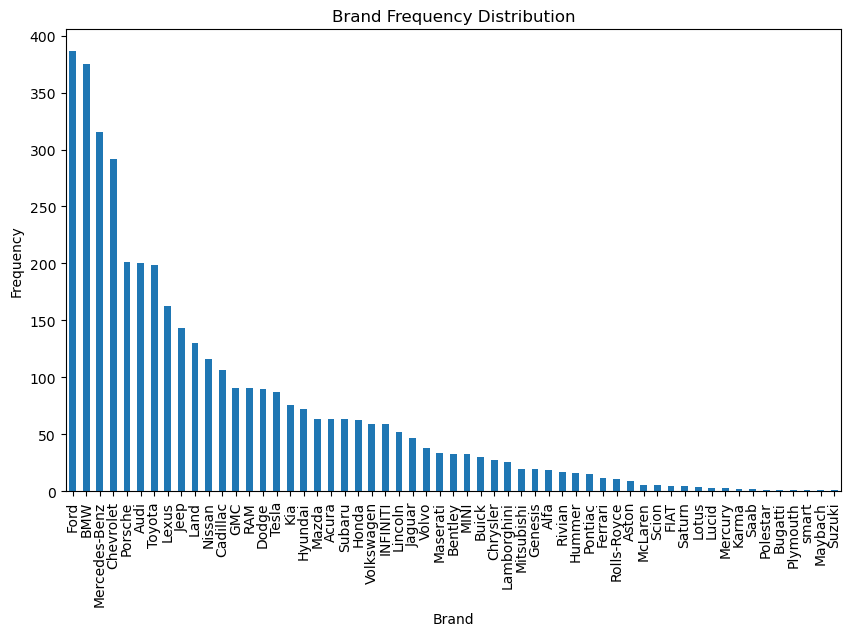

In [42]:
# Get the frequency distribution of the 'brand' column
brand_counts = df['brand'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
brand_counts.plot(kind='bar')
plt.title("Brand Frequency Distribution")
plt.xlabel("Brand")
plt.ylabel("Frequency")
plt.show()

In [43]:
# Choose a cutoff value and create a list of brands to be replaced
# use the variable name `brand_to_replace`
cutoff = 50

# Count occurrences
brand_counts = df.brand.value_counts()

# Vectorized replacement: Replace names with low counts
df['brand'] = np.where(df['brand'].isin(brand_counts[brand_counts < cutoff].index), "Other",df['brand'])

# Check result
print(df['brand'].value_counts())

brand
Other            450
Ford             386
BMW              375
Mercedes-Benz    315
Chevrolet        292
Porsche          201
Audi             200
Toyota           199
Lexus            163
Jeep             143
Land             130
Nissan           116
Cadillac         107
RAM               91
GMC               91
Dodge             90
Tesla             87
Kia               76
Hyundai           72
Subaru            64
Acura             64
Mazda             64
Honda             63
Volkswagen        59
INFINITI          59
Lincoln           52
Name: count, dtype: int64


In [46]:
df.transmission.value_counts().head(20)

transmission
A/T                               1037
8-Speed A/T                        406
Transmission w/Dual Shift Mode     398
6-Speed A/T                        362
6-Speed M/T                        248
Automatic                          237
7-Speed A/T                        209
8-Speed Automatic                  176
10-Speed A/T                       119
5-Speed A/T                         86
9-Speed A/T                         74
6-Speed Automatic                   73
4-Speed A/T                         72
1-Speed A/T                         64
CVT Transmission                    62
5-Speed M/T                         59
10-Speed Automatic                  56
9-Speed Automatic                   47
M/T                                 40
Automatic CVT                       37
Name: count, dtype: int64

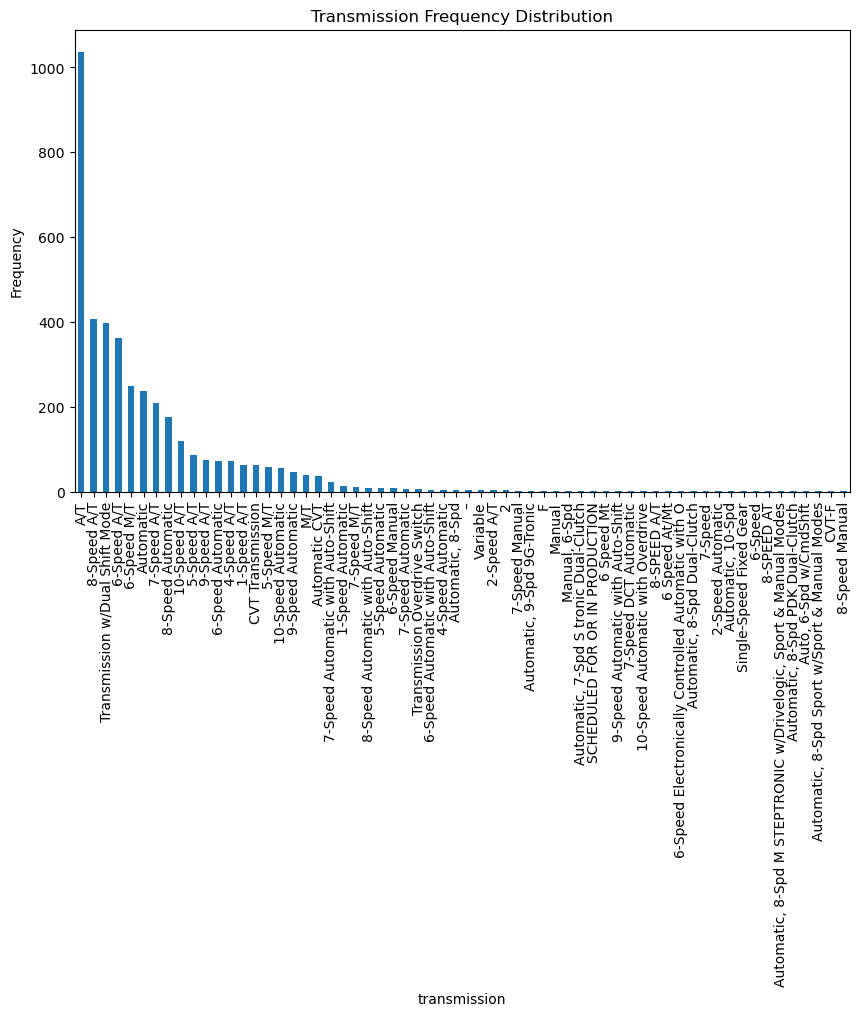

In [48]:
# Get the frequency distribution of the 'brand' column
transmission_counts = df['transmission'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
transmission_counts.plot(kind='bar')
plt.title("Transmission Frequency Distribution")
plt.ylabel("Frequency")
plt.show()

In [49]:
# Define a function to categorize transmissions
def categorize_transmission(transmission):
    # Convert to lowercase for easier matching
    transmission = str(transmission).lower()

    # Specific checks for different transmission types
    if 'automatic' in transmission or 'a/t' in transmission or 'cvt' in transmission or 'overdrive' in transmission or'variable' in transmission or'6-speed' in transmission or '7-speed' in transmission or '8-speed' in transmission:
        return 'Automatic'
    elif 'manual' in transmission or 'm/t' in transmission or 'single-speed fixed gear' in transmission:
        return 'Manual'
    elif 'dual shift mode' in transmission:
        return 'Dual-Shift' 
    else:
        return 'Other'  # For any unexpected values

# Apply the function to the 'transmission' column
df['transmission_category'] = df['transmission'].apply(categorize_transmission)

# Check the value counts to see how the categorization went
print(df['transmission_category'].value_counts())


transmission_category
Automatic     3494
Dual-Shift     398
Manual         104
Other           13
Name: count, dtype: int64


In [52]:
df.fuel_type.value_counts()

fuel_type
Gasoline          3309
Hybrid             194
Electric           171
E85 Flex Fuel      139
Diesel             116
Unknown             46
Plug-In Hybrid      34
Name: count, dtype: int64

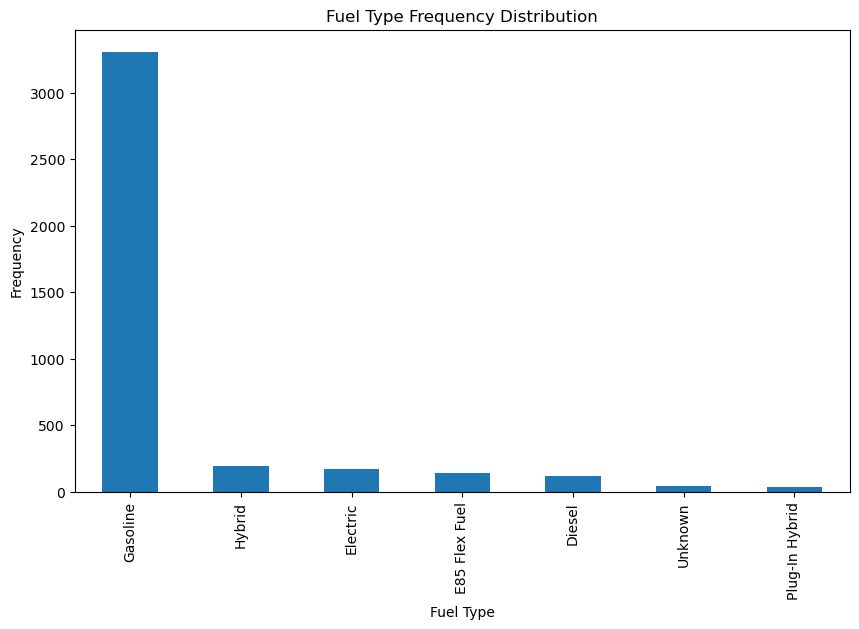

In [54]:
# Get the frequency distribution of the 'brand' column
fuel_type_counts = df['fuel_type'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
fuel_type_counts.plot(kind='bar')
plt.title("Fuel Type Frequency Distribution")
plt.xlabel("Fuel Type")
plt.ylabel("Frequency")
plt.show()

In [56]:
df.exterior_color.value_counts().head(20)

exterior_color
Black                                 905
White                                 816
Gray                                  496
Silver                                374
Blue                                  349
Red                                   261
Green                                  74
Brown                                  43
Gold                                   42
Beige                                  38
Orange                                 36
Yellow                                 29
–                                      15
Bright White Clearcoat                 14
Summit White                           14
Diamond Black                          14
Purple                                 12
Alpine White                            8
Granite Crystal Clearcoat Metallic      7
Silver Ice Metallic                     7
Name: count, dtype: int64

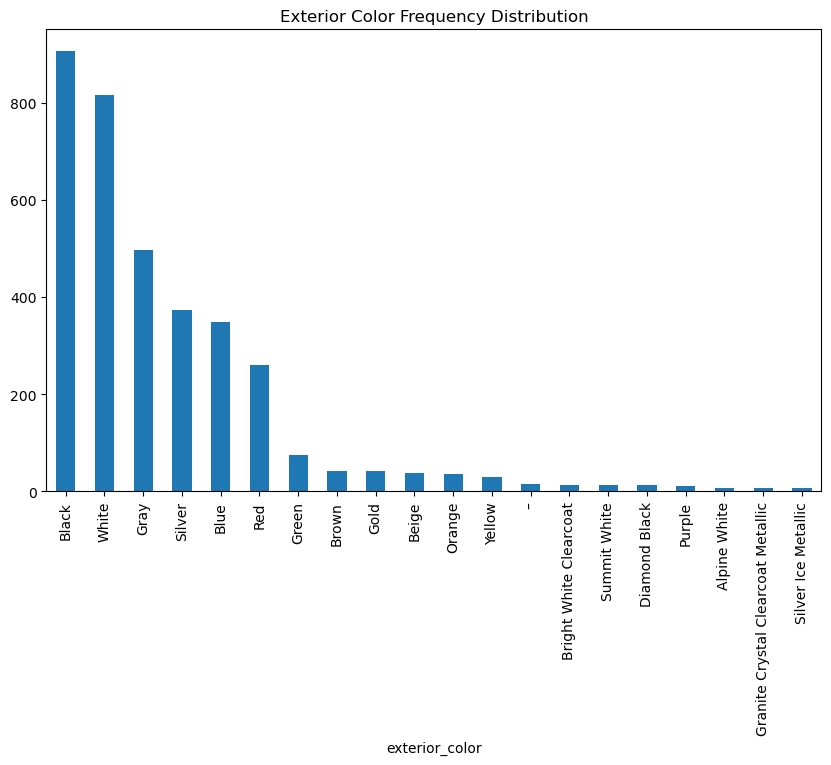

In [58]:
# Get the frequency distribution of the 'brand' column
exterior_color_counts = df['exterior_color'].value_counts().head(20)

# Plot the distribution
plt.figure(figsize=(10, 6))
exterior_color_counts.plot(kind='bar')
plt.title("Exterior Color Frequency Distribution")
plt.show()

In [60]:
# Define a mapping for grouping similar colors
color_mapping = {
    'Black': ['Black', 'Black Clearcoat', 'Black Sapphire Metallic', 'Midnight Black Metallic', 'Mythos Black Metallic', 'Diamond Black', 'Daytona Gray Pearl Effect', 'Majestic Black Pearl', 'Deep Black Pearl Effect', 'Ebony Twilight Metallic', 'Granite Crystal Clearcoat Metallic', 'Mosaic Black Metallic'],
    'White': ['White', 'Bright White Clearcoat', 'Summit White', 'Alpine White', 'Oxford White', 'Glacial White Pearl', 'Platinum White Pearl'],
    'Gray': ['Gray'],
    'Silver': ['Silver', 'Silver Ice Metallic', 'Brilliant Silver Metallic', 'Satin Steel Metallic', 'Lunar Silver Metallic'],
    'Red': ['Red', 'Delmonico Red Pearlcoat', 'Firecracker Red Clearcoat', 'Soul Red Crystal Metallic', 'Velvet Red Pearlcoat','Soul Red Crystal Metallic'],
    'Blue': ['Blue', 'Blu'],
    'Green': ['Green'],
    'Brown': ['Brown'],
    'Gold': ['Gold'],
    'Beige': ['Beige'],
    'Orange': ['Orange'],
    'Yellow': ['Yellow'],
    'Purple': ['Purple'],
    'Other': ['–']
}

# Function to group the exterior color
def group_colors(color):
    for group, colors in color_mapping.items():
        if color in colors:
            return group
    return 'Other'  # In case a color is not found in the mapping

# Apply the function to the 'exterior_color' column
df['exterior_color_category'] = df['exterior_color'].apply(group_colors)

# Check the grouped value counts
print(df['exterior_color_category'].value_counts())


exterior_color_category
Black     968
White     866
Gray      496
Silver    391
Other     385
Blue      352
Red       277
Green      74
Brown      43
Gold       42
Beige      38
Orange     36
Yellow     29
Purple     12
Name: count, dtype: int64


In [62]:
# Choose a cutoff value and create a list of exterior colors to be replaced
cutoff = 50

# Count occurrences of each exterior color
exterior_color_to_replace = df['exterior_color_category'].value_counts()

# Vectorized replacement: Replace colors with counts less than cutoff with "Other"
df['exterior_color_category'] = np.where(df['exterior_color_category'].isin(exterior_color_to_replace[exterior_color_to_replace < cutoff].index), "Other", df['exterior_color_category'])

# Check the result
print(df['exterior_color_category'].value_counts())


exterior_color_category
Black     968
White     866
Other     585
Gray      496
Silver    391
Blue      352
Red       277
Green      74
Name: count, dtype: int64


In [64]:
df.accident.value_counts()

accident
None reported                             2910
At least 1 accident or damage reported     986
Name: count, dtype: int64

In [66]:
# Replace 'None reported' with 'No accident' and 'At least 1 accident or damage reported' with 'Yes'
df['accident'] = df['accident'].fillna('Unknown')
df['accident'] = df['accident'].replace({
    'None reported': 'No',
    'At least 1 accident or damage reported': 'Yes'
})

In [68]:
df.accident.value_counts()

accident
No         2910
Yes         986
Unknown     113
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x214c4fee330>,
 [Text(-0.8344980890363697, -0.7166679422121849, 'No'),
  Text(0.8946070793939995, 0.6400610701317011, 'Yes'),
  Text(0.0972786455001635, 1.0956901318938916, 'Unknown')],
 [Text(-0.45518077583801975, -0.3909097866611917, '72.6%'),
  Text(0.48796749785127236, 0.34912422007183697, '24.6%'),
  Text(0.05306107936372554, 0.5976491628512135, '2.8%')])

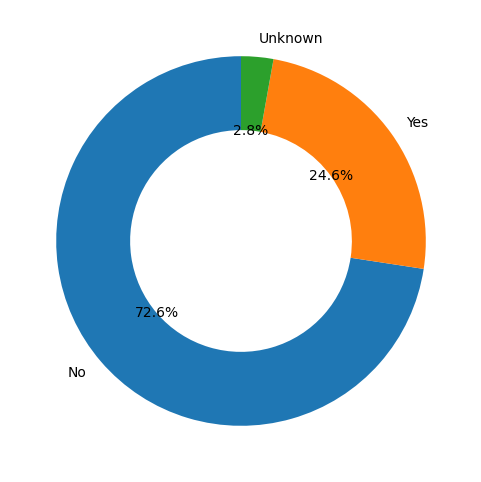

In [70]:
# Assuming df is defined and contains the 'accident' column
accident_counts = df['accident'].value_counts()

# Create a donut chart
plt.figure(figsize=(6, 6))
plt.pie(accident_counts, labels=accident_counts.index, autopct='%1.1f%%', startangle=90, 
        wedgeprops=dict(width=0.4))

In [72]:
df.clean_title.value_counts()

clean_title
Yes    3413
Name: count, dtype: int64

In [74]:
df['clean_title'] = df['clean_title'].fillna('No')

In [76]:
df.clean_title.value_counts()

clean_title
Yes    3413
No      596
Name: count, dtype: int64

In [78]:
df = df.drop(columns=['model', 'interior_color', 'engine', 'exterior_color', 'transmission'])

In [80]:
df.to_csv('../Resources/cleaned_data.csv', index=False)  # Save the DataFrame as a CSV file